# Features

- Education: https://ec.europa.eu/eurostat/web/products-datasets/-/trng_lfs_02
- Population: https://ec.europa.eu/eurostat/web/products-datasets/-/tps00001
- R&D expenditure: https://ec.europa.eu/eurostat/web/products-datasets/-/t2020_20
- Fertility rates by age: https://ec.europa.eu/eurostat/web/products-datasets/-/demo_frate
- Human resources in science and technology (HRST): https://ec.europa.eu/eurostat/web/products-datasets/-/tsc00025
- Tax rate: https://ec.europa.eu/eurostat/web/products-datasets/-/earn_nt_taxrate
- International trade, by reporting country, total product: https://ec.europa.eu/eurostat/web/products-datasets/-/tet00002
- ~~Gross domestic product: https://ec.europa.eu/eurostat/web/products-datasets/-/teina011~~
- ~~Funding of education: https://ec.europa.eu/eurostat/web/products-datasets/-/educ_fifunds~~

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import locale

data_raw_dir = '../data/raw'

## Preprocess

In [2]:
from iso3166 import countries
import re

country_code_dict = {
    'EL': 'GR',
    'UK': 'GB'
}

def country_code_to_name(code):
    if code in country_code_dict:
        code = country_code_dict[code]
    try:
        return countries.get(code).name
    except KeyError:
        return None
    
country_name_dict = {
    'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom',
}
    
def normalize_country_name(name):
    if name in country_name_dict:
        return country_name_dict[name]
    else:
        return name

flag_dict = {
    ':': 'not available',
    'p': 'provisional',
    'b': 'break in time series',
    'd': 'definition differs',
    'c': 'conditional',
    'e': 'estimated',
}

def extract_flags(p_str):
    flag = None
    for char in flag_dict:
        if char in p_str:
            flag = flag_dict[char]
            break
    return flag

def preprocess(df):
    # Rename
    columns_to_rename = {c: c.rstrip() for c in df.columns if c.endswith(' ')}
    raw_base_column = [c for c in df.columns if c.endswith('\\time')][0] # e.g. 'unit,isced11,sex,age,geo\\time'
    base_column = raw_base_column.replace('\\time', '')
    columns_to_rename[raw_base_column] = base_column
    df.rename(columns=columns_to_rename, inplace=True)
    
    # Unpivot
    df = df.melt(id_vars=base_column, var_name='year', value_name='value')
    
    # Split
    columns_to_split = base_column.split(',')
    df[columns_to_split] = df[base_column].str.split(',', expand=True)
    df.drop(columns=[base_column], inplace=True)
    
    # Normalize country name
    df.rename(columns={'geo': 'GEO'}, inplace=True)
    df['GEO'] = df['GEO'].apply(country_code_to_name)
    df['GEO'] = df['GEO'].apply(normalize_country_name)
    
    # Extract flags
    df['value'] = df['value'].astype(str)
    df['flags'] = df['value'].apply(lambda p_str: extract_flags(p_str))
    df['value'] = df['value'].apply(lambda p_str: re.sub('[^\d\.]', '', p_str))
    df['value'] = df['value'].replace('', None)
    
    # Convert data types
    df['year'] = df['year'].astype(int)
    df['value'] = pd.to_numeric(df['value'], errors='coerce')

    return df

## Education

In [3]:
education_df = pd.read_csv(f'{data_raw_dir}/trng_lfs_02.tsv.gz', delimiter='\t')
education_df.head()

,"unit,isced11,sex,age,geo\time",2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004
0,"PC,ED0-2,F,Y18-24,AT",61.5,64.6,63.8,61.6,60.7,60.2 b,69.8,68.3,66.9,67.0,64.9,62.5,59.5,58.8 b,60.7,59.3 b
1,"PC,ED0-2,F,Y18-24,BE",72.1,72.2,64.5 b,60.0,54.8,58.2 b,55.6,53.8,53.8,55.8,54.6,52.0 b,52.6,53.2 b,49.2,62.5 b
2,"PC,ED0-2,F,Y18-24,BG",50.8,48.6,48.1,45.3,46.1,48.8 b,49.0,47.5,52.4,51.6,50.5,50.6,54.2,47.7 b,42.1,45.1
3,"PC,ED0-2,F,Y18-24,CH",83.5,86.1,83.6,79.7,80.6,78.8 b,80.8,81.3,81.9,77.0 b,74.2,77.4,80.0,75.7,73.2,74.6
4,"PC,ED0-2,F,Y18-24,CY",31.1 u,44.3,40.2,50.1 u,61.1,57.9 bu,51.9,45.0,37.9,31.2,28.9 bu,25.0 u,41.7,26.3 bu,20.7 u,28.6


In [4]:
education_df = preprocess(education_df)
education_df.head()

,year,value,unit,isced11,sex,age,GEO,flags
0,2019,61.5,PC,ED0-2,F,Y18-24,Austria,None
1,2019,72.1,PC,ED0-2,F,Y18-24,Belgium,None
2,2019,50.8,PC,ED0-2,F,Y18-24,Bulgaria,None
3,2019,83.5,PC,ED0-2,F,Y18-24,Switzerland,None
4,2019,31.1,PC,ED0-2,F,Y18-24,Cyprus,None


In [5]:
temp = education_df[education_df['age'] == 'Y18-24']
education_agg = temp.groupby(['GEO','year'])['value'].mean().reset_index()
education_agg = education_agg.groupby(['GEO'])['value'].mean().reset_index()
education_agg['education_rank'] = education_agg['value'].rank(ascending=False).astype(int)
education_agg.head()

,GEO,value,education_rank
0,Austria,55.738542,14
1,Belgium,49.356696,26
2,Bulgaria,46.949479,28
3,Croatia,54.651250,17
4,Cyprus,39.348958,33


## Population

In [6]:
population_df = pd.read_csv(f'{data_raw_dir}/tps00001.tsv.gz', delimiter='\t')
population_df.head()

,"indic_de,geo\time",2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,"JAN,AD",83137,84484,84082,78115 b,78115,76246,:,:,71732,:,74794 e,76177
1,"JAN,AL",2958266,2936355,2918674,2907361,2903008,2897770,2892394,2885796,2875592,2876591,2870324,2862427
2,"JAN,AM",3230086,3237976,3249482,3262650,3274285,3026878,:,3010598,2998577,2986151,2972732,2965269
3,"JAN,AT",8307989,8335003,8351643,8375164,8408121,8451860,8507786,8584926,8700471,8772865,8822267,8858775
4,"JAN,AZ",8629900,8896900,8997586,9111078,9235085,9356483,9477119,9593038,9705643,9809981,9898085,9981457


In [7]:
population_df = preprocess(population_df)
population_df.head()

,year,value,indic_de,GEO,flags
0,2008,83137,JAN,Andorra,None
1,2008,2958266,JAN,Albania,None
2,2008,3230086,JAN,Armenia,None
3,2008,8307989,JAN,Austria,None
4,2008,8629900,JAN,Azerbaijan,None


In [8]:
population_df['indic_de'].unique()

array(['JAN'], dtype=object)

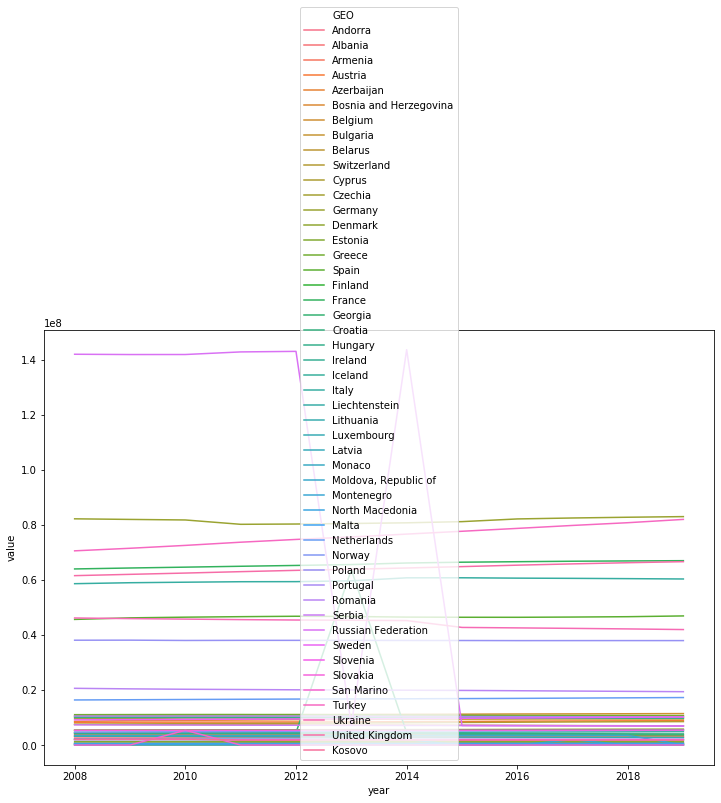

In [9]:
plt.figure(figsize=(12,8))
sns.lineplot(data=population_df, x='year', y='value', hue='GEO')
plt.show()

## R&D expenditure

In [10]:
rd_df = pd.read_csv(f'{data_raw_dir}/t2020_20.tsv.gz', delimiter='\t')
rd_df.drop(columns=['TARGET '], inplace=True)
rd_df.head()

,"unit,indic_eu,geo\time",1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,"PC_GDP,T2020_20,AT",:,:,:,:,:,1.53 e,1.58 e,1.66 e,1.73,...,2.6,2.73 e,2.67,2.91 e,2.95,3.08 e,3.05,3.12,3.05,3.17 p
1,"PC_GDP,T2020_20,BA",:,:,:,:,:,:,:,:,:,...,:,:,:,0.27,0.32,0.26,:,:,:,:
2,"PC_GDP,T2020_20,BE",:,:,:,:,:,1.65,1.74,1.81,1.84,...,2,2.06,2.17,2.28,2.33,2.37,2.43,2.52,2.66,2.76 p
3,"PC_GDP,T2020_20,BG",:,:,:,:,:,0.43,0.42 b,0.47,0.48,...,0.49,0.57,0.53,0.6,0.64,0.79,0.95,0.77,0.74,0.76
4,"PC_GDP,T2020_20,CH",:,:,2.38,:,:,:,2.45,:,:,...,:,:,:,3.19,:,:,3.37,:,3.29,:


In [11]:
rd_df = preprocess(rd_df)
rd_df.head()

,year,value,unit,indic_eu,GEO,flags
0,1990,NaN,PC_GDP,T2020_20,Austria,not available
1,1990,NaN,PC_GDP,T2020_20,Bosnia and Herzegovina,not available
2,1990,NaN,PC_GDP,T2020_20,Belgium,not available
3,1990,NaN,PC_GDP,T2020_20,Bulgaria,not available
4,1990,NaN,PC_GDP,T2020_20,Switzerland,not available


## Fertility Rates

In [12]:
frate_df = pd.read_csv(f'{data_raw_dir}/demo_frate.tsv.gz', delimiter='\t')
frate_df.head()

,"unit,age,agedef,geo\time",2018,2017,2016,2015,2014,2013,2012,2011,2010,...,1969,1968,1967,1966,1965,1964,1963,1962,1961,1960
0,"NR,TOTAL,COMPLET,AD",:,:,:,:,:,:,:,:,1.27491,...,:,:,:,:,:,:,:,:,:,:
1,"NR,TOTAL,COMPLET,AL",1.36807,1.47540,1.53794,1.59469,1.73440,1.72964,1.70506,1.64833,1.63118,...,:,:,:,:,:,:,:,:,:,:
2,"NR,TOTAL,COMPLET,AM",1.56746,1.56087,1.62480,1.62067,:,:,:,:,:,...,:,:,:,:,:,:,:,:,:,:
3,"NR,TOTAL,COMPLET,AT",1.47446,1.51755,1.52920,1.49020,1.46365,1.43547,1.43955,1.42994,1.44231,...,2.48572,2.58385,2.61916,2.65982,2.69995,2.79138,2.81888,2.79853,2.78429,2.69258
4,"NR,TOTAL,COMPLET,AZ",1.73095,1.75000,1.89964,1.94264,1.96592,1.97578,1.99712,:,1.92400,...,:,:,:,:,:,:,:,:,:,:


In [13]:
frate_df = preprocess(frate_df)
frate_df.head()

,year,value,unit,age,agedef,GEO,flags
0,2018,NaN,NR,TOTAL,COMPLET,Andorra,not available
1,2018,1.36807,NR,TOTAL,COMPLET,Albania,None
2,2018,1.56746,NR,TOTAL,COMPLET,Armenia,None
3,2018,1.47446,NR,TOTAL,COMPLET,Austria,None
4,2018,1.73095,NR,TOTAL,COMPLET,Azerbaijan,None


## Funding of education

In [14]:
education_funding_df = pd.read_csv(f'{data_raw_dir}/educ_fifunds.tsv.gz', delimiter='\t')
education_funding_df.head()

,"indic_ed,unit,geo\time",2011,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000,1999,1998,1997,1996,1995
0,"FS01_1,PC,AL",:,:,:,:,:,:,:,:,:,: u,:,:,:,:,:,:,:
1,"FS01_1,PC,AT",73.3,74.0,73.5,74.1,75.0,74.7,75.2,73.5,74.1,71.6,72.7,71.6,72.0,71.5,:,:,:
2,"FS01_1,PC,BE",23.1 d,22.2 d,22.2 d,20.7 d,19.8 d,18.3 d,18.0 d,17.8 d,17.6 d,18.5 d,16.7 d,4.2 d,3.8 d,:,:,:,:
3,"FS01_1,PC,BE_FRA",:,:,:,:,:,:,: u,: u,: u,: u,: u,:,:,:,:,:,:
4,"FS01_1,PC,BE_VLA",:,:,:,:,:,:,: u,: u,: u,:,:,:,:,:,:,:,:


In [15]:
education_funding_df = preprocess(education_funding_df)
education_funding_df.head()

,year,value,indic_ed,unit,GEO,flags
0,2011,NaN,FS01_1,PC,Albania,not available
1,2011,73.3,FS01_1,PC,Austria,None
2,2011,23.1,FS01_1,PC,Belgium,definition differs
3,2011,23.1,FS01_1,PC,None,not available
4,2011,23.1,FS01_1,PC,None,not available


## Human resources in science and technology (HRST)

In [16]:
hrst_df = pd.read_csv(f'{data_raw_dir}/tsc00025.tsv.gz', delimiter='\t')
hrst_df.head()

,"unit,category,age,sex,geo\time",2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,"PC_ACT,HRST,Y25-64,F,AT",35.8,37.4,37.6,38.4 b,40.0,42.5,49.0 b,48.6,49.7,51.2,51.2,52.3
1,"PC_ACT,HRST,Y25-64,F,BE",50.1 b,51.8,53.5,52.8 b,54.1,53.9,55.3 b,54.9,56.1,59.2 b,59.3,59.7
2,"PC_ACT,HRST,Y25-64,F,BG",37.8 b,38.6,39.8 b,40.0 b,40.0,41.6,43.3 b,44.5,45.2,44.4,44.7,44.2
3,"PC_ACT,HRST,Y25-64,F,CH",49.9,50.8,49.3 b,47.3 b,48.3,50.5,51.6 b,52.9,53.9,55.5,57.1,58.1
4,"PC_ACT,HRST,Y25-64,F,CY",47.3,46.3 b,46.7,50.9 b,51.2,50.9,52.9 b,53.1,55.4,56.0,56.9,58.8


In [17]:
hrst_df = preprocess(hrst_df)
hrst_df.head()

,year,value,unit,category,age,sex,GEO,flags
0,2008,35.8,PC_ACT,HRST,Y25-64,F,Austria,None
1,2008,50.1,PC_ACT,HRST,Y25-64,F,Belgium,break in time series
2,2008,37.8,PC_ACT,HRST,Y25-64,F,Bulgaria,break in time series
3,2008,49.9,PC_ACT,HRST,Y25-64,F,Switzerland,None
4,2008,47.3,PC_ACT,HRST,Y25-64,F,Cyprus,None


## Gross domestic product

In [18]:
gdp_df = pd.read_csv(f'{data_raw_dir}/teina011.tsv.gz', delimiter='\t')
gdp_df.head()

,"na_item,unit,geo\time",2017Q1,2017Q2,2017Q3,2017Q4,2018Q1,2018Q2,2018Q3,2018Q4,2019Q1,2019Q2,2019Q3,2019Q4
0,"B1GQ,PCH_Q1_SCA,AT",0.4,0.8,0.8,0.5,0.8,0.3,0.3,0.8,0.5,0.1,0.2,0.2
1,"B1GQ,PCH_Q1_SCA,BE",0.8,0.3,0.1,0.8,0.2,0.3,0.2,0.8,0.0,0.3,0.4,0.4
2,"B1GQ,PCH_Q1_SCA,BG",0.8,0.8,0.8,0.7,0.6,0.9,1.0,0.8,1.0 p,0.7 p,0.7 p,0.8 p
3,"B1GQ,PCH_Q1_SCA,CH",0.1,0.7,0.7,1.0,1.0,0.8,-0.4,-0.1,0.4,0.4,0.4,0.3
4,"B1GQ,PCH_Q1_SCA,CY",0.7,0.8,0.7,1.1,1.8,0.6,0.3,1.0,1.4,0.4,0.5,0.8


## Tax rate

In [19]:
tax_rate_df = pd.read_csv(f'{data_raw_dir}/earn_nt_taxrate.tsv.gz', delimiter='\t')
tax_rate_df.head()

,"ecase,geo\time",2019,2018,2017,2016,2015,2014,2013,2012,2011,...,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000
0,"A1_100,AT",33.21,32.79,32.43,32.11,35.04,34.68,34.38,33.94,33.55,...,32.79,34.26,33.84,33.44,33.04,33.22,32.00,31.60,31.39,30.96
1,"A1_100,BE",39.29,39.89,40.58,40.74,42.01,42.36,42.40,42.71,42.83,...,42.29,42.49,42.07,41.92,41.99,41.91,41.99,42.66,42.96,43.01
2,"A1_100,BG",22.40,22.40,22.01,21.61,21.61,21.61,21.61,21.61,21.61,...,21.70,21.70,:,:,:,:,:,:,:,:
3,"A1_100,CY",10.43,9.48,9.06,:,:,9.06,:,:,:,...,:,:,9.49,8.74,8.17,:,:,:,:,:
4,"A1_100,CZ",24.99,24.64,24.15,23.68,23.35,23.10,22.87,22.89,23.09,...,22.29,23.64,22.89,22.41,24.03,23.75,23.34,23.02,22.49,22.49


In [20]:
tax_rate_df = preprocess(tax_rate_df)
tax_rate_df.head()

,year,value,ecase,GEO,flags
0,2019,33.21,A1_100,Austria,None
1,2019,39.29,A1_100,Belgium,None
2,2019,22.40,A1_100,Bulgaria,None
3,2019,10.43,A1_100,Cyprus,None
4,2019,24.99,A1_100,Czechia,None


In [21]:
tax_rate_df['ecase'].unique()

array(['A1_100', 'A1_125', 'A1_167', 'A1_2CH_67', 'A1_50', 'A1_67',
       'A1_80', 'CPL_100_100', 'CPL_100_33', 'CPL_2CH_100_0',
       'CPL_2CH_100_100', 'CPL_2CH_100_33', 'CPL_2CH_100_67'],
      dtype=object)

## Imports of goods and services in % of GDP

In [22]:
imports_df = pd.read_csv(f'{data_raw_dir}/tet00004.tsv.gz', delimiter='\t')
imports_df.head()

,"na_item,unit,geo\time",2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,"P7,PC_GDP,AL",52.1 d,49.9,48.6,52.0,47.6,47.0,47.2,44.5,45.8,46.6,45.3 p,45.2 e
1,"P7,PC_GDP,AT",48.8,41.9,47.8,51.2,51.2,50.6,50.1,49.3,48.6,50.7,52.0,52.1
2,"P7,PC_GDP,BA",59.3,48.7,51.3,55.8,55.8,54.2,56.6,53.3,52.3,56.4,56.9,:
3,"P7,PC_GDP,BE",80.2,66.6,74.1,80.8,80.3,78.5,79.0,76.4,78.2,81.0,82.8,81.6
4,"P7,PC_GDP,BG",72.3,50.5,53.3,58.7,63.9,65.3,65.8,63.0,59.1,63.0,63.3,60.1 p


In [23]:
imports_df = preprocess(imports_df)
imports_df.head()

,year,value,na_item,unit,GEO,flags
0,2008,52.1,P7,PC_GDP,Albania,definition differs
1,2008,48.8,P7,PC_GDP,Austria,None
2,2008,59.3,P7,PC_GDP,Bosnia and Herzegovina,None
3,2008,80.2,P7,PC_GDP,Belgium,None
4,2008,72.3,P7,PC_GDP,Bulgaria,None


## International trade, by reporting country, total product

In [24]:
trade_df = pd.read_csv(f'{data_raw_dir}/tet00002.tsv.gz', delimiter='\t')
trade_df.head()

,"indic_et,sitc06,partner,geo\time",2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,"MIO_BAL_VAL,TOTAL,WORLD,AL",-3094.0,-2479.0,-2160.0,-2467.0,-2267.0,-1938.0,-2114.0,-2154.0,-2399.0,-2622,-2595,-2843
1,"MIO_BAL_VAL,TOTAL,WORLD,AT",-2042.6,-4355.4,-4865.0,-10050.2,-9263.9,-6115.3,-2828.7,-2942.4,-5102.1,-6819.9,-7578.8,-5289.3
2,"MIO_BAL_VAL,TOTAL,WORLD,BA",-4899.0,-3489.0,-3334.0,-3734.0,-3781.0,-3472.0,-3843.0,-3510.0,-3448.0,-3646,-3770,-4093
3,"MIO_BAL_VAL,TOTAL,WORLD,BE",3761.8,11618.7,12457.8,6270.8,5301.1,12862.8,13860.9,19201.9,16925.9,18522.7,11640.8,16540.7
4,"MIO_BAL_VAL,TOTAL,WORLD,BG",-9889.9,-5176.5,-3683.7,-3141.9,-4689.0,-3556.7,-4074.7,-3469.2,-2136.9,-2433.3,-3587.6,-3458.5


In [25]:
trade_df = preprocess(trade_df)
trade_df.head()

,year,value,indic_et,sitc06,partner,GEO,flags
0,2008,3094.0,MIO_BAL_VAL,TOTAL,WORLD,Albania,None
1,2008,2042.6,MIO_BAL_VAL,TOTAL,WORLD,Austria,None
2,2008,4899.0,MIO_BAL_VAL,TOTAL,WORLD,Bosnia and Herzegovina,None
3,2008,3761.8,MIO_BAL_VAL,TOTAL,WORLD,Belgium,None
4,2008,9889.9,MIO_BAL_VAL,TOTAL,WORLD,Bulgaria,None


In [26]:
trade_df['indic_et'].unique()

array(['MIO_BAL_VAL', 'MIO_EXP_VAL', 'MIO_IMP_VAL'], dtype=object)